# Anomaly Detection to detect hacking attempts
## Runar Helin

In [1]:
import itertools

import numpy  as np
import pandas as pd
 
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import IsolationForest

## Let us prepare the dataset for analysis
The dataset we will use is the hacking dataset from the KDD1999 competition. Each row corresponds to one connection and metadata of that connection (such as what kind of connection it was). Two classes are removed, namely the class for the SMURF attack and Neptune attack, which are so-called distributed denial of service attacks (DDoS). These attacks work by spamming connections

In [2]:
data = pd.read_csv('data/kdd1999_without_smurf_and_neptune.csv', index_col=0)

In [14]:
data.shape

(383258, 42)

In [3]:
data.head()

,duration: continuous,protocol_type: symbolic,service: symbolic,flag: symbolic,src_bytes: continuous,dst_bytes: continuous,land: symbolic,wrong_fragment: continuous,urgent: continuous,hot: continuous,...,dst_host_srv_count: continuous,dst_host_same_srv_rate: continuous,dst_host_diff_srv_rate: continuous,dst_host_same_src_port_rate: continuous,dst_host_srv_diff_host_rate: continuous,dst_host_serror_rate: continuous,dst_host_srv_serror_rate: continuous,dst_host_rerror_rate: continuous,dst_host_srv_rerror_rate: continuous,connection_type
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,234,1364,0,0,0,0,...,7,1.0,0.0,0.14,0.0,0.0,0.0,0.0,0.0,normal.


In [4]:
X, y = data.drop(['connection_type'], axis=1), data['connection_type']
X = pd.get_dummies(X)

y = (y=='normal.').astype(int)    # Normal connections will be class 1, attacks will be class 0
y = 2*y - 1                       # Sklearn anomaly detection algorithms return -1 for outliers and 1 for inliers

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.4, random_state=42)

### Let us check if indexes are the same on train_X and train_y

In [5]:
train_X.head()

,duration: continuous,src_bytes: continuous,dst_bytes: continuous,land: symbolic,wrong_fragment: continuous,urgent: continuous,hot: continuous,num_failed_logins: continuous,logged_in: symbolic,num_compromised: continuous,...,flag: symbolic_REJ,flag: symbolic_RSTO,flag: symbolic_RSTOS0,flag: symbolic_RSTR,flag: symbolic_S0,flag: symbolic_S1,flag: symbolic_S2,flag: symbolic_S3,flag: symbolic_SF,flag: symbolic_SH
536411,0,105,147,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
115203,0,306,868,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
49992,0,278,622,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
282474,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
305260,1,1135,332,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [6]:
train_y.head()

536411    1
115203    1
49992     1
282474    1
305260    1
Name: connection_type, dtype: int32

## Let us standardize the data

In [7]:
scaler = StandardScaler()
train_X =  scaler.fit_transform(train_X.values)
test_X = scaler.transform(test_X.values)

## Time to do some anomaly detection

In [8]:
train_y.value_counts() / len(train_y)

 1    0.955274
-1    0.044726
Name: connection_type, dtype: float64

In [9]:
iforest = IsolationForest(contamination=0.05, behaviour='new', random_state=1)
iforest.fit(train_X)
train_prediction = iforest.predict(train_X)
test_prediction = iforest.predict(test_X)

In [10]:
cm_train = metrics.confusion_matrix(train_y, train_prediction)
cm_test = metrics.confusion_matrix(test_y, test_prediction)

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))

    plt.yticks(tick_marks, classes)
    plt.xticks(tick_marks, classes, rotation=45)


    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):    # Same as a nested for loop
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

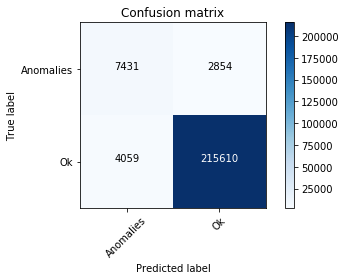

In [12]:
plot_confusion_matrix(cm_train, ['Anomalies', 'Ok'])

plt.show()

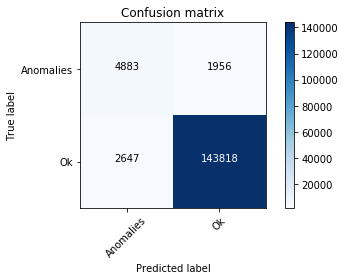

In [13]:
plot_confusion_matrix(cm_test, ['Anomalies', 'Ok'])
plt.show()

From this, we see that we detect the majority of hacking attempts, even when we don't have labeled training data. Furthermore, we see that the generalisation gap between the training and validation set is fairly low.